# Welfare Benefit Domain experiment

In [1]:
from wb_dataset import *
from wb_dataset_helpers import *
from neural_networks import *

from tqdm import tqdm
from joblib import Parallel, delayed
from ast import literal_eval

%load_ext autoreload
%autoreload 2

# Increase resolution of plots
plt.rcParams['figure.dpi'] = 80

# Show more columns
pd.set_option('display.max_column',None)

### Initialize global parameters

In [2]:
# dataset parameters
db_size = 2400 
# db_size = 50000
n_noise=52 #number of noise variables

# Network parameters
hidden_layers = [(12), (24, 6), (24,10,3)]
activation = 'logistic'
max_iter = 50000
learning_rate_init = 0.001
solver = 'adam'
batch_size = 50

### Initialize Regular Datasets

In [3]:
train_df = create_dataset(db_size, create_instance, fail_ratio=0.5, n_noise=n_noise)
test_df = create_dataset(db_size, create_instance, fail_ratio=0.5, n_noise=n_noise)

### Initialize Rationale Evaluation Datasets

In [4]:
ag_df = create_age_gender_dataset(db_size=1000, n_noise=n_noise)
co_df = create_contributions_dataset(db_size=1000, n_noise=n_noise)
sp_df = create_spouse_dataset(db_size=1000, n_noise=n_noise)
ab_df = create_absent_dataset(db_size=1000, n_noise=n_noise)
rs_df = create_resources_dataset(db_size=1000, n_noise=n_noise)
pd_df = create_patient_distance_dataset(db_size=1000, n_noise=n_noise)

### Initialize Tailored Dataset

In [5]:
tailored_df = create_dataset(db_size, create_instance_single_fail, fail_ratio=0.5, n_noise=n_noise)

### Preprocess 

In [6]:
# Create a scaler to normalize the data
scaler = create_scaler(create_dataset(db_size, create_instance, fail_ratio=0.5, n_noise=n_noise))

# Apply preprocessing to all data
train_X, train_y = preprocess(train_df, scaler, return_df=True)
test_X, test_y = preprocess(test_df, scaler, return_df=True)
tailored_X, tailored_y = preprocess(tailored_df, scaler, return_df=True)
ag_X, ag_y = preprocess(ag_df, scaler)
co_X, co_y = preprocess(co_df, scaler)
sp_X, sp_y = preprocess(sp_df, scaler)
ab_X, ab_y = preprocess(ab_df, scaler)
rs_X, rs_y = preprocess(rs_df, scaler)
pd_X, pd_y = preprocess(pd_df, scaler)

### Train Networks

In [7]:
def create_network(layers):
    return MLPClassifier(activation=activation, hidden_layer_sizes=layers, 
                         max_iter=max_iter, learning_rate_init=learning_rate_init,
                         solver=solver, batch_size=batch_size)

def train_networks(nn, X, y):
    nn.fit(X, y)
    return nn

In [8]:
# Create and train the neural networks on regular training dataset
neural_nets = [create_network(hls) for hls in hidden_layers]   
neural_nets = Parallel(n_jobs=-1)(delayed(train_networks)(nn, train_X, train_y) 
                                 for nn in tqdm(neural_nets))

# # Create and train the neural networks on tailored training dataset
neural_nets_tailored = [create_network(hls) for hls in hidden_layers]
neural_nets_tailored = Parallel(n_jobs=-1)(delayed(train_networks)(nn, tailored_X, tailored_y) 
                                 for nn in tqdm(neural_nets_tailored))

100%|██████████| 3/3 [00:00<00:00, 5735.15it/s]


## Explain the networks using XAI techniques: SHAP and LIME

#### SHAP

In [ ]:
import shap
shap.initjs()

def show_shap(nn, train_X, test_X, filename=None, samples=100):
    explainer = shap.KernelExplainer(nn.predict_proba, shap.sample(train_X, samples))
    shap_values = explainer.shap_values(shap.sample(test_X, samples))
    shap.summary_plot(shap_values, 
                      shap.sample(test_X, samples), 
                      class_names=['ineligible', 'eligible'], 
                      plot_type="bar", 
                      show=False)
    plt.xlim([0, 0.27])
    if filename:
        plt.savefig(filename, bbox_inches='tight')
        plt.clf()

In [ ]:
for idx, nn in enumerate(neural_nets):
    if idx > 0: continue
    show_shap(nn, 
              train_X,
              test_X,
              'results/shap/wb_'+str(idx+1)+'.png'
             )
for idx, nn in enumerate(neural_nets_tailored):
    if idx > 0: continue
    show_shap(nn, 
              tailored_X,
              test_X,
              'results/shap/wb_tailored_'+str(idx+1)+'.png'
             )

#### LIME

In [ ]:
from lime import lime_tabular
import random 

def show_lime(nn, train_X, test_X, test_y, features, idx=None, filename=None, show=False, num_features=20):
    class_names = ['ineligible', 'eligible']
    
    # Create LIME explainer using the training data
    explainer = lime_tabular.LimeTabularExplainer(train_X, mode="classification",
                                              class_names=class_names,
                                              feature_names=features)
    
    # Give explanation for a random instance from the test data
    if not idx: idx = random.randint(1, len(test_X))
    
    explanation = explainer.explain_instance(test_X[idx], 
                                             nn.predict_proba,
                                             num_features=num_features)
    if filename: 
        explanation.save_to_file(filename+'.html')
    if show: 
        explanation.show_in_notebook(show_table=False, show_all=False)

In [ ]:
# Preprocess the datasets as numpy array for LIME
test_X_arr, test_y_arr = preprocess(test_df, scaler, return_df=False)
train_X_arr, train_y_arr = preprocess(train_df, scaler, return_df=False)

In [ ]:
# Show the lime explanation for a random instance of the test set
show_lime(neural_nets[0], train_X_arr, test_X_arr, test_y_arr, train_df.columns, filename='results/lime/wb_A'+str(1)+'_lime', show=True)

## Compare LIME and SHAP explanations

In [ ]:
def explain_shap_instance(nn, idx, which_class, num_features=20, filename=None):
    '''
    Used to explain a single instance using shap.
    '''
    explainer = shap.KernelExplainer(nn.predict_proba, shap.sample(train_X, 100))
    shap_values = explainer.shap_values(shap.sample(pd.DataFrame(test_X.iloc[instance]).T, 100))
    exp = shap.Explanation(values=shap_values[int(which_class)][0],#[idx], 
                 base_values=explainer.expected_value[int(which_class)], 
                 feature_names=test_X.columns.tolist(),
                        data=test_X.iloc[idx],)
    shap.plots.bar(exp, max_display=num_features, show=False)
    if filename:
        plt.savefig(filename, bbox_inches='tight')
        plt.clf()
    shap.plots.bar(exp, max_display=num_features)

In [ ]:
# Select an instance that you wish to compare
instance = 0
which_class = test_y[instance]
nn = neural_nets[0]
nn_tailored = neural_nets_tailored[0]
print('Comparing explanations for instance', instance, 'which is', ['Ineligible', 'Eligible'][which_class])
row = pd.DataFrame(test_X.iloc[instance]).T

# Show the lime and shap explanations of the networks trained on a regular training set for the given instance
print('Trained on regular training set:')
show_lime(nn, train_X_arr, test_X_arr, test_y_arr, train_df.columns, idx=instance, show=True, num_features=15)
explain_shap_instance(nn, idx, which_class, num_features=15)

# Show the lime and shap explanations of the networks trained on a tailored training set for the given instance
print('Trained on tailored training set')
show_lime(nn_tailored, train_X_arr, test_X_arr, test_y_arr, train_df.columns, idx=instance, show=True, num_features=15)
explain_shap_instance(nn_tailored, idx, which_class, num_features=15)
row

## Test performance of each network on the regular dataset and rationale evaluation datasets


In [ ]:
# Store the predictions of the networks in their respective dataframes
for idx, (nn, nn_tailored) in enumerate(zip(neural_nets, neural_nets_tailored)):
    test_df['prediction_'+str(idx+1)] = nn.predict_proba(test_X)[:,1]
    ag_df['prediction_'+str(idx+1)] = nn.predict_proba(ag_X)[:,1]
    co_df['prediction_'+str(idx+1)] = nn.predict_proba(co_X)[:,1]
    sp_df['prediction_'+str(idx+1)] = nn.predict_proba(sp_X)[:,1]
    ab_df['prediction_'+str(idx+1)] = nn.predict_proba(ab_X)[:,1]
    rs_df['prediction_'+str(idx+1)] = nn.predict_proba(rs_X)[:,1]
    pd_df['prediction_'+str(idx+1)] = nn.predict_proba(pd_X)[:,1]
    
    test_df['prediction_tailored_'+str(idx+1)] = nn_tailored.predict_proba(test_X)[:,1]
    ag_df['prediction_tailored_'+str(idx+1)] = nn_tailored.predict_proba(ag_X)[:,1]
    co_df['prediction_tailored_'+str(idx+1)] = nn_tailored.predict_proba(co_X)[:,1]
    sp_df['prediction_tailored_'+str(idx+1)] = nn_tailored.predict_proba(sp_X)[:,1]
    ab_df['prediction_tailored_'+str(idx+1)] = nn_tailored.predict_proba(ab_X)[:,1]
    rs_df['prediction_tailored_'+str(idx+1)] = nn_tailored.predict_proba(rs_X)[:,1]
    pd_df['prediction_tailored_'+str(idx+1)] = nn_tailored.predict_proba(pd_X)[:,1]

In [ ]:
# Show accuracies of networks trained on a regular training set 
accs_A = pd.DataFrame.from_dict({'Regular '+str(idx+1) + ' layers': {
    'test': round(100*accuracy_score(test_y, nn.predict(test_X)), 2),
    'ag': round(100*accuracy_score(ag_y, nn.predict(ag_X)), 2),
    'co': round(100*accuracy_score(co_y, nn.predict(co_X)), 2),
    'sp': round(100*accuracy_score(sp_y, nn.predict(sp_X)), 2),
    'ab': round(100*accuracy_score(ab_y, nn.predict(ab_X)), 2),
    'rs': round(100*accuracy_score(rs_y, nn.predict(rs_X)), 2),
    'pd': round(100*accuracy_score(pd_y, nn.predict(pd_X)), 2),
} for idx, nn in enumerate(neural_nets)}, orient='index')
accs_A

In [ ]:
# Show accuracies of networks trained on a tailored training set
accs_B = pd.DataFrame.from_dict({'Tailored '+str(idx+1) + ' layers':{
    'test': round(100*accuracy_score(test_y, nn.predict(test_X)), 2),
    'ag': round(100*accuracy_score(ag_y, nn.predict(ag_X)), 2),
    'co': round(100*accuracy_score(co_y, nn.predict(co_X)), 2),
    'sp': round(100*accuracy_score(sp_y, nn.predict(sp_X)), 2),
    'ab': round(100*accuracy_score(ab_y, nn.predict(ab_X)), 2),
    'rs': round(100*accuracy_score(rs_y, nn.predict(rs_X)), 2),
    'pd': round(100*accuracy_score(pd_y, nn.predict(pd_X)), 2),
} for idx, nn in enumerate(neural_nets_tailored)}, orient='index')
accs_B

In [ ]:
# Investigate false positive / false negative rate after training on B
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for idx, (nn, nn_tailored) in enumerate(zip(neural_nets, neural_nets_tailored)):
    test_df['prediction_'+str(idx+1)] = nn.predict(test_X)
    test_df['prediction_tailored_'+str(idx+1)] = nn_tailored.predict(test_X)

y_true = test_df['eligible']
y_pred = test_df['prediction_3']
print('Training on a regular training set')
print('Accuracy on a regular test set:', round(100*accuracy_score(y_true, y_pred), 2), '%')
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['uneligible', 'eligible'])
disp.plot()
plt.show()

y_pred = test_df['prediction_tailored_3']
print('Training on a tailored training set')
print('Accuracy on a regular test set:', round(100*accuracy_score(y_true, y_pred), 2), '%')
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['uneligible', 'eligible'])
disp.plot()
plt.show()

### Explore the Rationale visually for networks trained on regular training datasets

In [ ]:
# Plot the age versus the output for each gender and each network
plot_output(ag_df, 'gender', 'age', ['m', 'f'], predict='prediction_',
            legend_values=['Male', 'Female'], xlabel='Age')

# Plot the distance versus the output for each patient type and each network
plot_output(pd_df, 'patient_type', 'distance_to_hospital', ['out', 'in'], predict='prediction_',
           legend_values=['Out-patient', 'In-patient'], xlabel='Distance to hospital')

### Explore the Rationale visually for networks trained on tailored training datasets

In [ ]:
# Plot the age versus the output for each gender and each network
plot_output(ag_df, 'gender', 'age', ['m', 'f'], predict='prediction_tailored_',
            legend_values=['Male', 'Female'], xlabel='Age')

# Plot the distance versus the output for each patient type and each network
plot_output(pd_df, 'patient_type', 'distance_to_hospital', ['out', 'in'], predict='prediction_tailored_',
            legend_values=['Out-patient', 'In-patient'], xlabel='Distance to hospital')

### Run the experiment multiple times

In [ ]:
def convert_accs(accs):
    '''
    Converts list of accuracies to mean and std
    '''
    return str(round(np.mean(accs), 2)) + ' ± ' + str(round(np.std(accs), 2))   

def merge_accuracies(accuracies):
    '''
    Merge the list of accuracies to a pandas dataframe with mean and standard deviations
    '''
    accs = copy.deepcopy(accuracies)
    results = accs[0]
    for idx, x in enumerate(accs):
        if idx == 0: continue
        for train_name, train_data in x.items():
            for test_name, test_data in train_data.items():
                if type(results[train_name][test_name]) == str:
                    results[train_name][test_name] = literal_eval(results[train_name][test_name])
                if type(test_data) == str:
                    test_data = literal_eval(test_data)
                results[train_name][test_name].append(test_data[0])
                if idx == len(accs)-1:
                    results[train_name][test_name] = convert_accs(results[train_name][test_name])
    return pd.DataFrame.from_dict(results).T

def run_experiment(scaler, exp2=False):
    '''
    Train and test neural networks
    :param scaler: the scaler used to normalize the data
    :param exp2: set this to true if you wish to run the rationale improvement experiment
    :return: all of the accuracies of the experiment that was run
    '''

    accuracies = {}

    # Training datasets
    datasets_train = {}
    if exp2: # the rationale improvement experiment
        for rat_B in [x/100 for x in range(0, 105, 5)]:
            rat_A = 1 - rat_B
            datasets_train[str(rat_B)] = create_dataset(db_size*rat_A, create_instance, fail_ratio=0.5, n_noise=n_noise).append(
                create_dataset(db_size*rat_B, create_instance_single_fail, fail_ratio=0.5, n_noise=n_noise))
    else: # The regular experiment   
        datasets_train = {
            'train' : create_dataset(db_size, create_instance, fail_ratio=0.5, n_noise=n_noise),
            'train_tailored' : create_dataset(db_size, create_instance_single_fail, fail_ratio=0.5, n_noise=n_noise),
        }
    preprocessed_train = {name: preprocess(df, scaler) for name, df in datasets_train.items()}

    # Test datasets
    datasets_test = {
        'test' : create_dataset(db_size, create_instance, fail_ratio=0.5, n_noise=n_noise),
        'ag' : create_age_gender_dataset(db_size=1000, n_noise=n_noise),
        'co' : create_contributions_dataset(db_size=50, n_noise=n_noise),
        'sp' : create_spouse_dataset(db_size=1000, n_noise=n_noise),
        'ab' : create_absent_dataset(db_size=1000, n_noise=n_noise),
        'rs' : create_resources_dataset(db_size=50, n_noise=n_noise),
        'pd' : create_patient_distance_dataset(db_size=1000, n_noise=n_noise),   
    }
    preprocessed_test = {name: preprocess(df, scaler) for name, df in datasets_test.items()}
    
    for train_name, train_data in preprocessed_train.items():       
        # Create and train the neural networks on training set A
        neural_nets = [create_network(hls) for hls in hidden_layers]   
        neural_nets = Parallel(n_jobs=1)(delayed(train_networks)(nn, train_data[0], train_data[1]) 
                                         for nn in neural_nets)
        
        # Initialize accuracies data
        for idx, nn in enumerate(neural_nets):
            accuracies[train_name+'_'+str(idx+1)] = {test_name: [] for test_name in preprocessed_test.keys()}

        # Add accuracies
        for test_name, test_data in preprocessed_test.items():
            for idx, nn in enumerate(neural_nets):
                accuracies[train_name+'_'+str(idx+1)][test_name].append(100*accuracy_score(test_data[1], nn.predict(test_data[0])))
    datasets_test.clear()
    datasets_train.clear()
    
    
    return accuracies

In [5]:
# Number of runs
num_runs = 50

# Dataset size
db_size = 2400
# db_size = 50000 #More data

# Create a scaler to normalize the data
scaler = create_scaler(create_dataset(db_size, create_instance, fail_ratio=0.5, n_noise=n_noise))   
accuracies = Parallel(n_jobs=-1)(delayed(run_experiment)(scaler) for run in tqdm(range(0, num_runs)))
results = merge_accuracies(accuracies)
results.to_csv('results/accuracies/50_runs.csv')
# results.to_csv('results/accuracies/50_runs_more_data.csv')
results

100%|██████████| 50/50 [03:07<00:00,  3.76s/it] 


,test_A,test_B,ag,co,sp,ab,rs,pd
train_A_1,98.88 ± 0.22,72.12 ± 1.79,51.36 ± 3.12,65.41 ± 4.86,72.46 ± 6.49,93.23 ± 4.73,63.36 ± 5.56,50.07 ± 0.12
train_A_2,98.83 ± 0.26,72.13 ± 1.9,52.25 ± 3.39,68.9 ± 4.48,74.06 ± 6.73,90.16 ± 6.31,62.53 ± 5.57,50.08 ± 0.13
train_A_3,98.88 ± 0.24,70.82 ± 1.81,49.9 ± 2.61,70.65 ± 4.88,73.36 ± 5.2,86.62 ± 6.85,58.33 ± 5.77,50.06 ± 0.09
train_A75_B25_1,98.32 ± 0.41,84.01 ± 1.85,74.54 ± 3.86,67.1 ± 5.18,97.74 ± 0.71,98.57 ± 0.54,78.84 ± 2.59,62.08 ± 8.76
train_A75_B25_2,98.17 ± 0.55,83.31 ± 1.36,75.4 ± 4.1,68.26 ± 5.0,97.84 ± 0.63,98.3 ± 0.76,77.78 ± 3.48,57.71 ± 6.48
train_A75_B25_3,98.39 ± 0.5,82.46 ± 1.16,74.89 ± 4.63,68.13 ± 5.22,97.89 ± 0.83,98.58 ± 0.59,78.37 ± 3.9,51.79 ± 2.11
train_A50_B50_1,97.48 ± 0.53,87.98 ± 2.37,81.65 ± 2.28,77.44 ± 4.41,97.36 ± 0.54,97.63 ± 0.55,82.91 ± 1.78,76.46 ± 11.44
train_A50_B50_2,97.13 ± 0.71,86.76 ± 2.1,81.97 ± 2.17,76.19 ± 4.63,97.28 ± 0.66,97.28 ± 0.74,82.29 ± 2.47,69.66 ± 12.4
train_A50_B50_3,97.55 ± 0.61,85.15 ± 1.47,81.36 ± 2.16,74.73 ± 4.36,97.63 ± 0.62,97.7 ± 0.71,81.02 ± 2.72,60.92 ± 8.38
train_A25_B75_1,96.7 ± 0.67,89.78 ± 1.78,84.57 ± 1.63,82.45 ± 3.4,96.73 ± 0.58,96.78 ± 0.57,85.04 ± 1.18,82.84 ± 8.38


## Investigating the effects of training set B

In [19]:
# Number of runs
num_runs = 500
start = 400
db_size = 50000
hls = hidden_layers = [(24,10,3)]


# Create a scaler to normalize the data
scaler = create_scaler(create_dataset(db_size, create_instance, fail_ratio=0.5, n_noise=n_noise))
accuracies = Parallel(n_jobs=10)(delayed(run_experiment)(scaler, True, run) for run in tqdm(range(start, start+num_runs)))
results = merge_accuracies(accuracies)
results.to_csv('results/accuracies/500_runs_rationale_improvement.csv')
results

100%|██████████| 101/101 [5:19:25<00:00, 189.76s/it] 


,test_A,test_B,ag,co,sp,ab,rs,pd
0.0_1,99.78 ± 0.05,82.53 ± 1.75,64.37 ± 4.28,83.5 ± 4.31,97.1 ± 2.12,95.87 ± 2.76,69.81 ± 3.8,62.96 ± 3.35
0.05_1,99.75 ± 0.13,93.34 ± 0.84,86.54 ± 2.27,93.26 ± 3.07,99.81 ± 0.19,99.78 ± 0.18,87.91 ± 2.02,85.75 ± 1.83
0.1_1,99.69 ± 0.18,94.74 ± 0.72,89.55 ± 2.06,95.31 ± 2.14,99.73 ± 0.23,99.73 ± 0.19,90.63 ± 1.7,88.93 ± 1.66
0.15_1,99.62 ± 0.2,95.51 ± 0.58,91.19 ± 1.84,96.84 ± 1.62,99.65 ± 0.26,99.65 ± 0.26,91.99 ± 1.25,90.7 ± 1.33
0.2_1,99.55 ± 0.28,96.02 ± 0.6,92.62 ± 1.8,97.37 ± 1.49,99.6 ± 0.31,99.58 ± 0.29,92.88 ± 1.51,91.87 ± 1.42
0.25_1,99.5 ± 0.31,96.29 ± 0.48,93.28 ± 1.59,97.9 ± 1.25,99.5 ± 0.36,99.54 ± 0.33,93.43 ± 1.18,92.4 ± 1.2
0.3_1,99.42 ± 0.38,96.49 ± 0.38,93.82 ± 1.45,98.25 ± 1.01,99.47 ± 0.41,99.46 ± 0.39,93.84 ± 1.04,92.99 ± 1.1
0.35_1,99.42 ± 0.38,96.74 ± 0.35,94.59 ± 1.19,98.41 ± 0.81,99.46 ± 0.41,99.4 ± 0.41,94.24 ± 1.03,93.47 ± 1.05
0.4_1,99.39 ± 0.32,96.91 ± 0.37,94.89 ± 1.25,98.54 ± 0.72,99.42 ± 0.36,99.43 ± 0.35,94.6 ± 1.13,93.9 ± 0.98
0.45_1,99.33 ± 0.41,96.93 ± 0.37,95.13 ± 1.16,98.7 ± 0.74,99.34 ± 0.46,99.34 ± 0.47,94.66 ± 1.19,93.97 ± 1.08


### Plot the accuracies for the rationale improvement experiment

In [23]:
from scipy.interpolate import interp1d

label_size = 15
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 


def plotAccuracies(col, filename=None, interp=False, scaled=False, bar=False, show=False, show_numbers=False):
    '''
    Plots the accuracies of neural networks trained using various percentages of tailored instances.
    :param col: the particular test set that we are examining (one column out of the dataframe)
    :param interp: True if using an interpolator to smoothen the graph
    :param scaled: True when using a fixed scale for the y axis
    :param bar: True when displaying bar plots rather than graphs
    :param show: True when displaying the plot
    :show_numbers: True when displaying images on top of the bars in the bar plot
    '''
    
    names = {
        'test_A': 'Test set',
        'ag': 'Age-Gender',
        'co': 'Contributions',
        'sp': 'Spouse',
        'ab': 'Absent',
        'rs': 'Resources',
        'pd': 'Patient-Distance',
    }
    
    
    y = [float(x.split(' ')[0]) for x in results[col]]
    x = range(0,105,5)
    
    if bar:
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.bar(x, y, width=4)
        plt.ylim([min(y)-np.std(y)/4, max(y)+np.std(y)/4])
        if show_numbers:
            for bars in ax.containers:
                ax.bar_label(bars, fontsize=6)
        if scaled:
            plt.ylim([60, 101])

    else:
        if interp:
            # Define interpolators.
            f_linear = interp1d(x, y)
            f_cubic = interp1d(x, y, kind='cubic')
            xnew = np.linspace(0, 100, num=100, endpoint=True)

            plt.plot(x, y, 'o', label='data')
            plt.plot(xnew, f_linear(xnew), '-', label='linear')
            plt.plot(xnew, f_cubic(xnew), '--', label='cubic')
            plt.legend(loc='best')
        else:
            plt.plot(x, y)

        if scaled:
            plt.ylim([60, 100])

    plt.xlabel("% tailored instances", fontsize=label_size)
    plt.ylabel("Accuracy", fontsize=label_size)
    plt.title(names[col], fontdict={'fontsize':label_size})
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

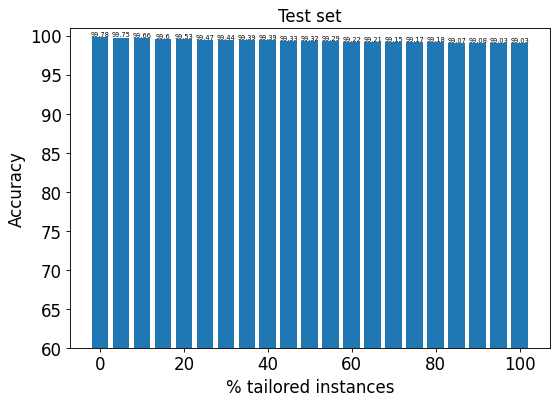

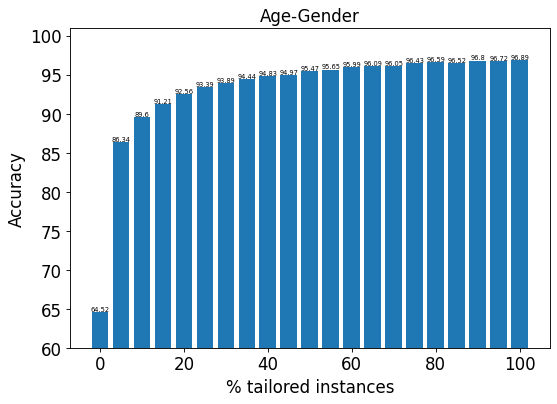

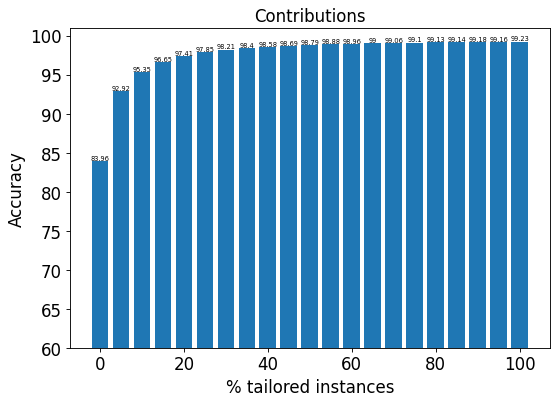

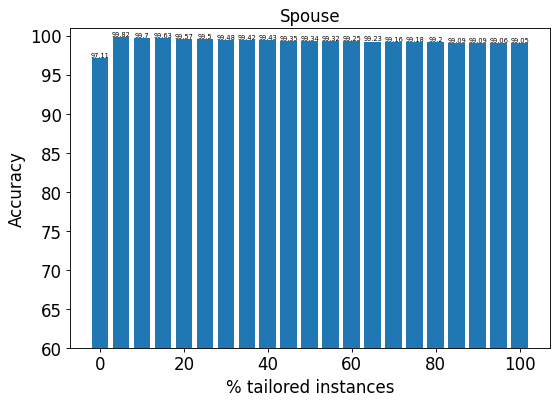

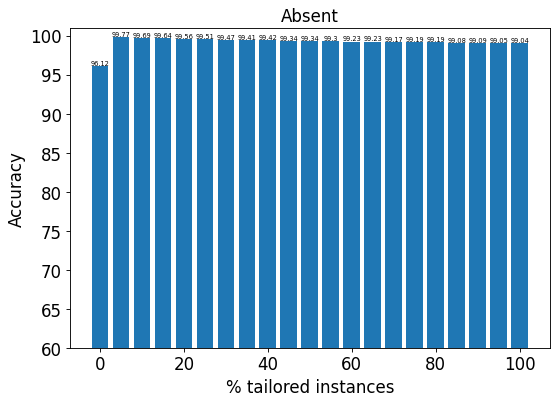

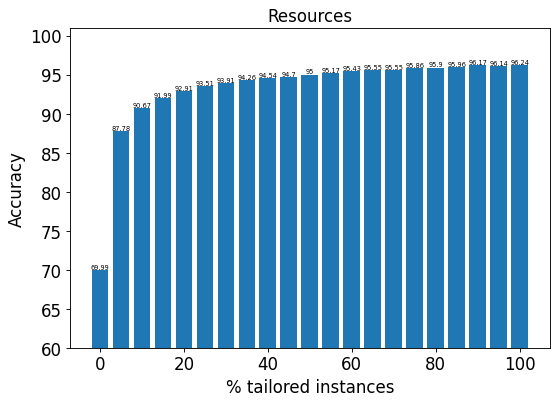

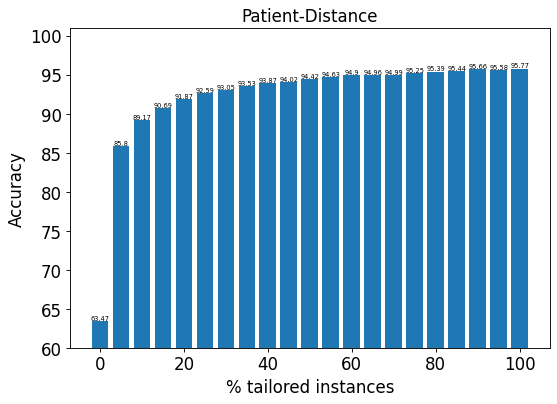

In [24]:
results = pd.read_csv('results/accuracies/500_runs_rationale_improvement.csv', index_col=0)
for test_set in ['test_A', 'ag',  'co', 'sp', 'ab', 'rs', 'pd']:
    plotAccuracies(test_set, scaled=True, bar=True, show_numbers=True)